# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

In [2]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

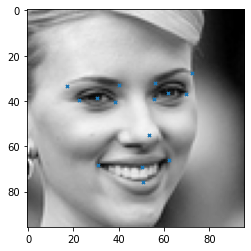

In [3]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [4]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                1105950   
Total params: 1,143,518
Trainable params: 1,143,518
Non-trainable params: 0
____________

2021-11-07 13:29:32.553730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-07 13:29:32.553853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam", metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

2021-11-07 13:29:32.630145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-07 13:29:32.630315: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-07 13:29:32.748649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.5712

2021-11-07 13:29:33.800245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 105ms/step - loss: 0.3619 - accuracy: 0.5712 - val_loss: 0.1723 - val_accuracy: 0.7267
Epoch 2/50
11/11 [==============================] - 1s 65ms/step - loss: 0.1559 - accuracy: 0.6981 - val_loss: 0.1379 - val_accuracy: 0.7267
Epoch 3/50
11/11 [==============================] - 1s 65ms/step - loss: 0.1205 - accuracy: 0.6966 - val_loss: 0.1135 - val_accuracy: 0.7267
Epoch 4/50
11/11 [==============================] - 1s 64ms/step - loss: 0.0889 - accuracy: 0.6966 - val_loss: 0.0732 - val_accuracy: 0.7267
Epoch 5/50
11/11 [==============================] - 1s 84ms/step - loss: 0.0719 - accuracy: 0.6966 - val_loss: 0.0769 - val_accuracy: 0.7267
Epoch 6/50
11/11 [==============================] - 1s 65ms/step - loss: 0.0679 - accuracy: 0.6966 - val_loss: 0.0652 - val_accuracy: 0.7267
Epoch 7/50
11/11 [==============================] - 1s 64ms/step - loss: 0.0592 - accuracy: 0.7025 - val_loss: 0.0602 - val_accuracy: 0.7467
Epoch 8/50
11/11 [=====

In [7]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  2.0191526


2021-11-07 13:30:09.375922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [8]:
import matplotlib.pyplot as plt

def plot_train_loss(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

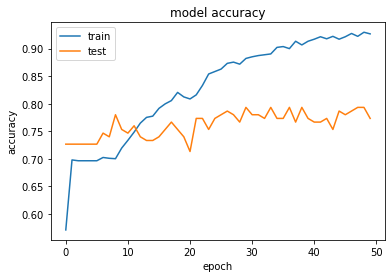

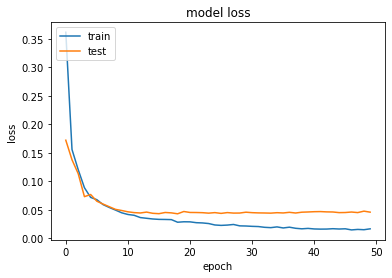

In [9]:
plot_train_loss(history)

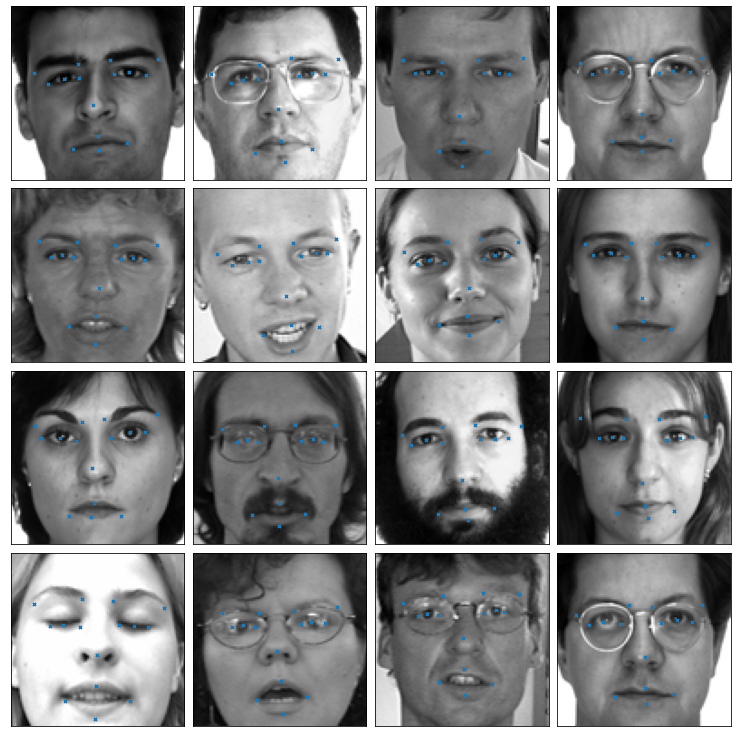

In [10]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

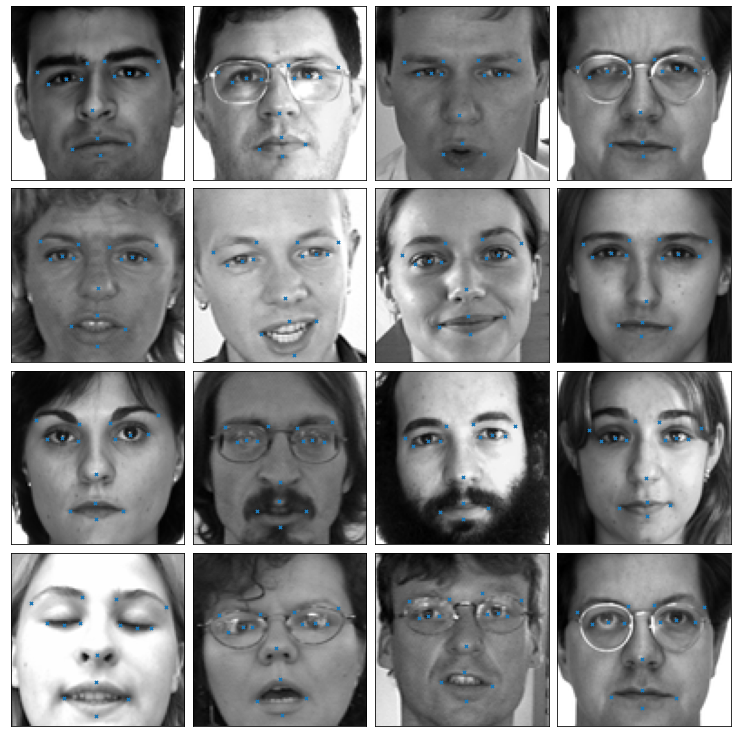

In [11]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# My code

## 1.1 Improvement on the previous model

In [12]:
# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu", input_shape=[96, 96, 1]))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(30, activation="linear"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 19, 19, 128)      

In [13]:
batch_size = 128
epochs = 100

model.compile(loss=root_mean_squared_error, optimizer="adam", metrics = ['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100


2021-11-07 13:30:10.623025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 150ms/step - loss: 0.2737 - accuracy: 0.2455 - val_loss: 0.1705 - val_accuracy: 0.2600
Epoch 2/100
 1/11 [=>............................] - ETA: 0s - loss: 0.1912 - accuracy: 0.1797

2021-11-07 13:30:12.552405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 129ms/step - loss: 0.1564 - accuracy: 0.2737 - val_loss: 0.0982 - val_accuracy: 0.7267
Epoch 3/100
11/11 [==============================] - 1s 104ms/step - loss: 0.1171 - accuracy: 0.4644 - val_loss: 0.0708 - val_accuracy: 0.7267
Epoch 4/100
11/11 [==============================] - 1s 103ms/step - loss: 0.1049 - accuracy: 0.4881 - val_loss: 0.0713 - val_accuracy: 0.7267
Epoch 5/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0955 - accuracy: 0.5497 - val_loss: 0.0691 - val_accuracy: 0.7267
Epoch 6/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0909 - accuracy: 0.5542 - val_loss: 0.0696 - val_accuracy: 0.7267
Epoch 7/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0884 - accuracy: 0.5786 - val_loss: 0.0699 - val_accuracy: 0.7267
Epoch 8/100
11/11 [==============================] - 1s 112ms/step - loss: 0.0852 - accuracy: 0.6313 - val_loss: 0.0687 - val_accuracy: 0.7267
Epoch 9/100

11/11 [==============================] - 1s 115ms/step - loss: 0.0393 - accuracy: 0.7693 - val_loss: 0.0350 - val_accuracy: 0.7933
Epoch 60/100
11/11 [==============================] - 1s 115ms/step - loss: 0.0385 - accuracy: 0.7545 - val_loss: 0.0364 - val_accuracy: 0.7667
Epoch 61/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0384 - accuracy: 0.7634 - val_loss: 0.0349 - val_accuracy: 0.7867
Epoch 62/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0379 - accuracy: 0.7500 - val_loss: 0.0348 - val_accuracy: 0.7733
Epoch 63/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0375 - accuracy: 0.7537 - val_loss: 0.0348 - val_accuracy: 0.8000
Epoch 64/100
11/11 [==============================] - 1s 118ms/step - loss: 0.0375 - accuracy: 0.7641 - val_loss: 0.0359 - val_accuracy: 0.8133
Epoch 65/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0375 - accuracy: 0.7782 - val_loss: 0.0345 - val_accuracy: 0.7933
Epoch

In [14]:
y_new = model.predict(x_valid)
print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  1.481542


2021-11-07 13:32:16.902836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


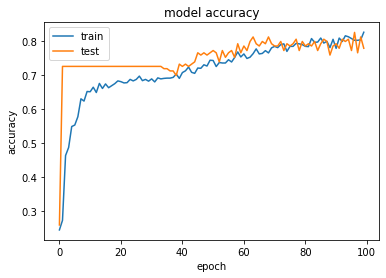

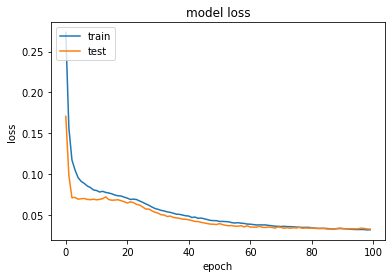

In [15]:
plot_train_loss(history)

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import *
from keras import backend as K
import pandas as pd
import copy

# Data Augmentation

In [17]:
keyfacial_df = pd.read_csv(FTRAIN)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))
keyfacial_df = keyfacial_df.dropna()

In [18]:
columns = keyfacial_df.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [19]:
keyfacial_df_copy = copy.copy(keyfacial_df)

In [20]:
# randomly increase the brightness of images
# Multiply the pixel values by random values between 1.5 and 2 to increase the brightness of the image.
# Crop the value between 0 and 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))
augmented_df.shape

(4280, 31)

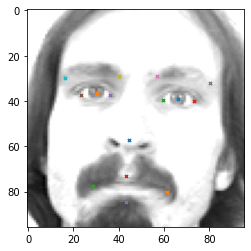

In [21]:
pyplot.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    pyplot.scatter(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], marker='x', s=10)

In [22]:
# We get the value of the images that is present in column 31 (since the index starts from 0, we refer to column 31 by 30 in Python).
img = augmented_df[:,30]

# We normalise the images 
img = img/255.

# Create an empty array of size (x, 96, 96, 1) to supply to the model.
X = np.empty((len(img), 96, 96, 1))

# Iterate over the list of images and add the nusnas to the empty array after expanding its dimension from (96, 96) to (96, 96, 1).
for i in range(len(img)):
    X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(4280, 96, 96, 1)

In [23]:
y = augmented_df[:,:30]
y = (y - 48) / 48
y.shape

(4280, 30)

In [24]:
X, y = shuffle(X, y, random_state=42)
y = y.astype(np.float32)

In [25]:
# We split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# 1.2 Model with data augmentation

In [26]:
# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu", input_shape=[96, 96, 1]))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(30, activation="linear"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 94, 94, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 92, 92, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 19, 19, 128)      

In [27]:
batch_size = 128
epochs = 100

model.compile(loss=root_mean_squared_error, optimizer="adam", metrics = ['accuracy'])

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[tb_callback])

Epoch 1/100


2021-11-07 13:32:21.257162: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 13:32:21.257171: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 13:32:21.257233: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 13:32:21.475660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/22 [=>............................] - ETA: 2s - loss: 0.3561 - accuracy: 0.1406 

2021-11-07 13:32:21.883509: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 13:32:21.883523: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 13:32:21.996642: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-07 13:32:21.997370: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 13:32:21.999576: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_11_07_13_32_21

2021-11-07 13:32:22.000686: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_11_07_13_32_21/MBP-de-Johnny.home.trace.json.gz
2021-11-07 13:32:22.001847: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_11_07_13_32_21

2021-11-07 13:32:

22/22 [==============================] - 3s 129ms/step - loss: 0.2240 - accuracy: 0.2493 - val_loss: 0.1111 - val_accuracy: 0.6667
Epoch 2/100


2021-11-07 13:32:24.454412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 110ms/step - loss: 0.1156 - accuracy: 0.4203 - val_loss: 0.0696 - val_accuracy: 0.6667
Epoch 3/100
22/22 [==============================] - 3s 119ms/step - loss: 0.0953 - accuracy: 0.5171 - val_loss: 0.0711 - val_accuracy: 0.6667
Epoch 4/100
22/22 [==============================] - 2s 112ms/step - loss: 0.0876 - accuracy: 0.5953 - val_loss: 0.0715 - val_accuracy: 0.6667
Epoch 5/100
22/22 [==============================] - 2s 112ms/step - loss: 0.0830 - accuracy: 0.5994 - val_loss: 0.0670 - val_accuracy: 0.6667
Epoch 6/100
22/22 [==============================] - 2s 111ms/step - loss: 0.0791 - accuracy: 0.6409 - val_loss: 0.0741 - val_accuracy: 0.6667
Epoch 7/100
22/22 [==============================] - 2s 112ms/step - loss: 0.0791 - accuracy: 0.6524 - val_loss: 0.0686 - val_accuracy: 0.6667
Epoch 8/100
22/22 [==============================] - 3s 120ms/step - loss: 0.0760 - accuracy: 0.6580 - val_loss: 0.0673 - val_accuracy: 0.6667
Epoch 9/100

22/22 [==============================] - 2s 114ms/step - loss: 0.0307 - accuracy: 0.8194 - val_loss: 0.0294 - val_accuracy: 0.8033
Epoch 60/100
22/22 [==============================] - 3s 118ms/step - loss: 0.0305 - accuracy: 0.8231 - val_loss: 0.0301 - val_accuracy: 0.8033
Epoch 61/100
22/22 [==============================] - 2s 112ms/step - loss: 0.0304 - accuracy: 0.8123 - val_loss: 0.0291 - val_accuracy: 0.8067
Epoch 62/100
22/22 [==============================] - 3s 116ms/step - loss: 0.0301 - accuracy: 0.8297 - val_loss: 0.0292 - val_accuracy: 0.8200
Epoch 63/100
22/22 [==============================] - 2s 114ms/step - loss: 0.0303 - accuracy: 0.8194 - val_loss: 0.0290 - val_accuracy: 0.8100
Epoch 64/100
22/22 [==============================] - 2s 114ms/step - loss: 0.0300 - accuracy: 0.8171 - val_loss: 0.0282 - val_accuracy: 0.8100
Epoch 65/100
22/22 [==============================] - 2s 114ms/step - loss: 0.0296 - accuracy: 0.8305 - val_loss: 0.0291 - val_accuracy: 0.8100
Epoch

In [28]:
y_new = model.predict(x_valid)
print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

2021-11-07 13:36:36.647162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean pixel error:  1.1834589


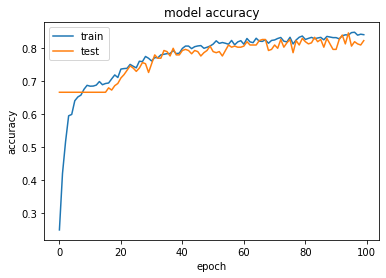

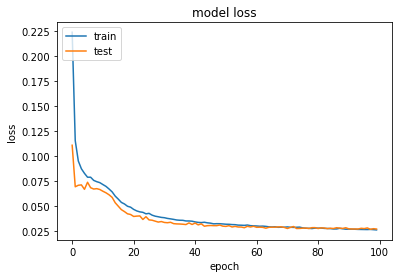

In [29]:
plot_train_loss(history)

In [30]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))
result = model.evaluate(x_test, y_test)
print("Accuracy : {}".format(result[1]))

Mean pixel error:  1.1834589
21/21 [==============================] - 0s 18ms/step - loss: 0.0243 - accuracy: 0.8520
Accuracy : 0.8520249724388123


# 1.3 Programming a ResNet

In [31]:
def res_block(X, filter, stage):

    # Convolutional Block
    X_copy = X

    f1 , f2, f3 = filter

    # Main Road
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


    # Short Road
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # Add
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 1
    X_copy = X


    # Main Road
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # Add
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    # Identity Block 2
    X_copy = X


    # Main Road
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # Add
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [32]:
input_shape = (96, 96, 1)

# Input tensor size
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - Phase
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - Phase
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - Phase
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - Phase
#X = res_block(X, filter= [256,256,1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final Layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'linear')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [33]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = root_mean_squared_error, optimizer = adam , metrics = ['accuracy'])
# Comprueba más sobre el Optimizador Adam en : https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [34]:
# We keep the best model with the best validation error. 
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [35]:
history = model_1_facialKeyPoints.fit(x_train, y_train, batch_size = 32, epochs = 200, validation_split = 0.1, callbacks=[checkpointer])

Epoch 1/200


2021-11-07 13:36:38.506940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.3275

2021-11-07 13:36:43.439964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 6s 56ms/step - loss: 0.3042 - accuracy: 0.3275 - val_loss: 0.2556 - val_accuracy: 0.5700

Epoch 00001: val_loss improved from inf to 0.25561, saving model to FacialKeyPoints_weights.hdf5


/Users/johnny/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
85/85 [==============================] - 3s 35ms/step - loss: 0.1020 - accuracy: 0.5508 - val_loss: 0.1603 - val_accuracy: 0.2900

Epoch 00002: val_loss improved from 0.25561 to 0.16033, saving model to FacialKeyPoints_weights.hdf5
Epoch 3/200
85/85 [==============================] - 3s 34ms/step - loss: 0.0879 - accuracy: 0.6009 - val_loss: 0.0962 - val_accuracy: 0.3300

Epoch 00003: val_loss improved from 0.16033 to 0.09622, saving model to FacialKeyPoints_weights.hdf5
Epoch 4/200
85/85 [==============================] - 3s 36ms/step - loss: 0.0811 - accuracy: 0.6224 - val_loss: 0.0770 - val_accuracy: 0.6600

Epoch 00004: val_loss improved from 0.09622 to 0.07704, saving model to FacialKeyPoints_weights.hdf5
Epoch 5/200
85/85 [==============================] - 3s 34ms/step - loss: 0.0762 - accuracy: 0.6484 - val_loss: 0.0724 - val_accuracy: 0.6667

Epoch 00005: val_loss improved from 0.07704 to 0.07245, saving model to FacialKeyPoints_weights.hdf5
Epoch 6/200
85/85 [=====


Epoch 00037: val_loss did not improve from 0.04425
Epoch 38/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0412 - accuracy: 0.7889 - val_loss: 0.0481 - val_accuracy: 0.7567

Epoch 00038: val_loss did not improve from 0.04425
Epoch 39/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0404 - accuracy: 0.7882 - val_loss: 0.0443 - val_accuracy: 0.7367

Epoch 00039: val_loss did not improve from 0.04425
Epoch 40/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0401 - accuracy: 0.7930 - val_loss: 0.0437 - val_accuracy: 0.7200

Epoch 00040: val_loss improved from 0.04425 to 0.04367, saving model to FacialKeyPoints_weights.hdf5
Epoch 41/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0395 - accuracy: 0.7901 - val_loss: 0.0443 - val_accuracy: 0.7700

Epoch 00041: val_loss did not improve from 0.04367
Epoch 42/200
85/85 [==============================] - 3s 34ms/step - loss: 0.0384 - accuracy: 0.7901 - val_loss: 0.043


Epoch 00076: val_loss did not improve from 0.03750
Epoch 77/200
85/85 [==============================] - 3s 34ms/step - loss: 0.0299 - accuracy: 0.8349 - val_loss: 0.0390 - val_accuracy: 0.7767

Epoch 00077: val_loss did not improve from 0.03750
Epoch 78/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0296 - accuracy: 0.8357 - val_loss: 0.0409 - val_accuracy: 0.7867

Epoch 00078: val_loss did not improve from 0.03750
Epoch 79/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0294 - accuracy: 0.8427 - val_loss: 0.0381 - val_accuracy: 0.7900

Epoch 00079: val_loss did not improve from 0.03750
Epoch 80/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0291 - accuracy: 0.8501 - val_loss: 0.0375 - val_accuracy: 0.7767

Epoch 00080: val_loss did not improve from 0.03750
Epoch 81/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0294 - accuracy: 0.8457 - val_loss: 0.0379 - val_accuracy: 0.7900

Epoch 00081: val_loss di


Epoch 00116: val_loss did not improve from 0.03442
Epoch 117/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0233 - accuracy: 0.8702 - val_loss: 0.0360 - val_accuracy: 0.8000

Epoch 00117: val_loss did not improve from 0.03442
Epoch 118/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0228 - accuracy: 0.8620 - val_loss: 0.0351 - val_accuracy: 0.7967

Epoch 00118: val_loss did not improve from 0.03442
Epoch 119/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0232 - accuracy: 0.8728 - val_loss: 0.0350 - val_accuracy: 0.7867

Epoch 00119: val_loss did not improve from 0.03442
Epoch 120/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0228 - accuracy: 0.8668 - val_loss: 0.0340 - val_accuracy: 0.7933

Epoch 00120: val_loss improved from 0.03442 to 0.03398, saving model to FacialKeyPoints_weights.hdf5
Epoch 121/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0224 - accuracy: 0.8750 - val_loss: 

85/85 [==============================] - 3s 35ms/step - loss: 0.0190 - accuracy: 0.8987 - val_loss: 0.0327 - val_accuracy: 0.8167

Epoch 00157: val_loss did not improve from 0.03256
Epoch 158/200
85/85 [==============================] - 3s 36ms/step - loss: 0.0190 - accuracy: 0.8954 - val_loss: 0.0327 - val_accuracy: 0.8033

Epoch 00158: val_loss did not improve from 0.03256
Epoch 159/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0187 - accuracy: 0.9002 - val_loss: 0.0321 - val_accuracy: 0.8200

Epoch 00159: val_loss improved from 0.03256 to 0.03214, saving model to FacialKeyPoints_weights.hdf5
Epoch 160/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0186 - accuracy: 0.8976 - val_loss: 0.0330 - val_accuracy: 0.8000

Epoch 00160: val_loss did not improve from 0.03214
Epoch 161/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0188 - accuracy: 0.8999 - val_loss: 0.0323 - val_accuracy: 0.8133

Epoch 00161: val_loss did not impro

85/85 [==============================] - 3s 35ms/step - loss: 0.0167 - accuracy: 0.9121 - val_loss: 0.0314 - val_accuracy: 0.8200

Epoch 00198: val_loss did not improve from 0.03096
Epoch 199/200
85/85 [==============================] - 3s 36ms/step - loss: 0.0165 - accuracy: 0.9114 - val_loss: 0.0313 - val_accuracy: 0.8400

Epoch 00199: val_loss did not improve from 0.03096
Epoch 200/200
85/85 [==============================] - 3s 35ms/step - loss: 0.0163 - accuracy: 0.9154 - val_loss: 0.0322 - val_accuracy: 0.8133

Epoch 00200: val_loss did not improve from 0.03096


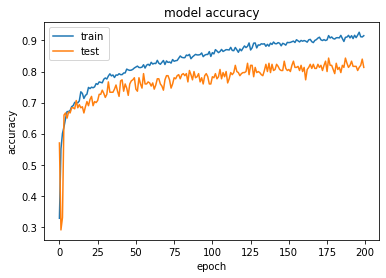

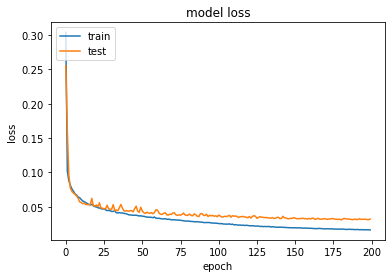

In [42]:
plot_train_loss(history)

In [43]:
# We save the architecture of the model in a JSON for later use.
model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
    json_file.write(model_json)


In [44]:
with open('FacialKeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# Load the model architecture
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
"""
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss=root_mean_squared_error, optimizer= adam , metrics = ['accuracy'])
"""

"\nadam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)\nmodel_1_facialKeyPoints.compile(loss=root_mean_squared_error, optimizer= adam , metrics = ['accuracy'])\n"

In [46]:
y_new = model_1_facialKeyPoints.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  1.4074209


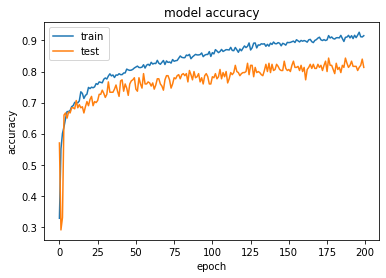

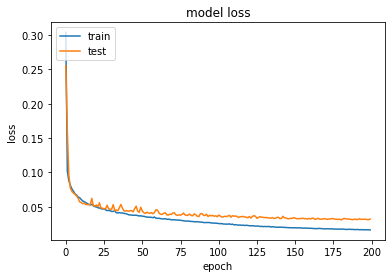

In [47]:
plot_train_loss(history)

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: 



### First of all I tried to improve the result by using a model with more convolutional and dense layers and then adding some dropout. With this, I managed to improve the score to 1.4362042. Then I tried to do data augmentation with flip points but I think that the change before regularizing was wrong, so finally I did data augmentation with the brightness. I achieved a maximum score of 1.18. Then, I have continued interested in the ResNet shown in class, and I have implemented a small version in Keras, giving me as a result maximum result 1.344829 and final 1.40 with only 200 iterations.